# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import keras as K
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28 * 28 = 784

learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальне число епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковій підмножині з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат і точності

n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)

class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, який складається з 128 нейронів
    self.layer1 = DenseLayer(num_features, n_hidden_1, name='layer1')

    # Другий шар, який складається з 256 нейронів
    self.layer2 = DenseLayer(n_hidden_1, n_hidden_2, name='layer2')

    # Вихідний шар
    self.output_layer = DenseLayer(n_hidden_2, num_classes, name='out_layer')


  def __call__(self, x):
    # Передача даних через перші два шари та вихідний шар з функцією активації softmax
    x = self.layer1(x, activation=0)
    x = self.layer2(x, activation=0)
    x = self.output_layer(x, activation=1)

    return x

In [5]:
# В якості функції помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Закодувати label в one hot vector
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Значення передбачення, щоб уникнути помилки log(0).
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Зробимо порівняння передбачених значеннь з істинними лейблами
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))

    # Визначимо середню точність використовуючи метод згортання
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="mnist")

# Функція навчання нейромережі
def train(neural_net, input_x, output_y):
  # Для налаштування вагів мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Отримаємо список оптимізованих параметрів
    trainable_variables = neural_net.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []  # кожні display_step кроків зберігай в цьому списку поточну помилку нейромережі
accuracy_history = [] # кожні display_step кроків зберігай в цьому списку поточну точність нейромережі

# У цьому циклі ми будемо проводити навчання нейронної мережі
# із тренувального датасета train_data вилучи випадкову підмножину, на якій
# відбудеться тренування. Використовуй метод take, доступний для тренувального датасета.
for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        loss = cross_entropy(pred, batch_y)
        acc = accuracy(pred, batch_y)
        loss_history.append(loss)
        accuracy_history.append(acc)

        print(f"Step {step}, Loss: {loss.numpy()}, Accuracy: {acc.numpy()}")

Step 100, Loss: 256.9591064453125, Accuracy: 0.71875
Step 200, Loss: 221.33163452148438, Accuracy: 0.76953125
Step 300, Loss: 152.42832946777344, Accuracy: 0.80078125
Step 400, Loss: 153.43783569335938, Accuracy: 0.828125
Step 500, Loss: 130.9171905517578, Accuracy: 0.87109375
Step 600, Loss: 125.4515609741211, Accuracy: 0.8203125
Step 700, Loss: 104.38154602050781, Accuracy: 0.8828125
Step 800, Loss: 150.5669708251953, Accuracy: 0.82421875
Step 900, Loss: 138.17568969726562, Accuracy: 0.84765625
Step 1000, Loss: 121.10893249511719, Accuracy: 0.8828125
Step 1100, Loss: 87.88824462890625, Accuracy: 0.8828125
Step 1200, Loss: 109.99124145507812, Accuracy: 0.88671875
Step 1300, Loss: 76.43972778320312, Accuracy: 0.8984375
Step 1400, Loss: 78.82070922851562, Accuracy: 0.87890625
Step 1500, Loss: 60.1844482421875, Accuracy: 0.9375
Step 1600, Loss: 74.25689697265625, Accuracy: 0.92578125
Step 1700, Loss: 98.69406127929688, Accuracy: 0.87890625
Step 1800, Loss: 56.655426025390625, Accuracy: 0

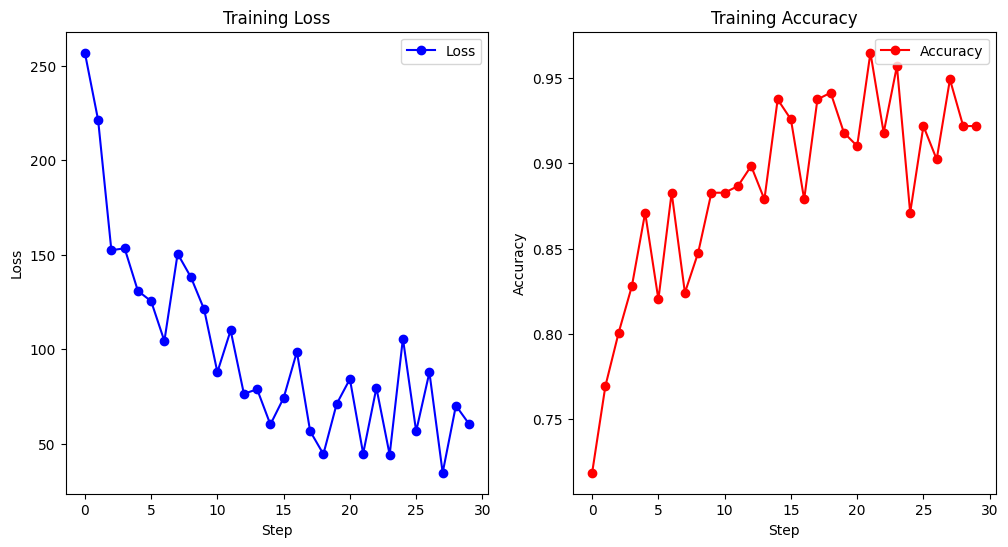

In [8]:
# Виведіть графіки залежності зміни точності і втрат від кроку
# Якщо все зроблено правильно, то точність повинна зростати, а втрати зменшуватись

import matplotlib.pyplot as plt

# Виведіть графік функції втрат
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss', marker='o', linestyle='-', color='blue')
plt.title('Training Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend()

# Виведіть графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy', marker='o', linestyle='-', color='red')
plt.title('Training Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [9]:
# Обчисліть точність навченої нейромережі
from sklearn.metrics import classification_report

# Отримуємо прогнози моделі для тестових зображень
predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Виводимо класифікаційний звіт
print(classification_report(y_test, predicted_labels))


predictions = neural_net(x_test)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

# Обчислюємо матрицю плутанини
cm = confusion_matrix(y_test, predicted_labels)

# Виводимо матрицю плутанини
print("\nМатриця плутанини:")
print(cm)

              precision    recall  f1-score   support

           0       0.96      0.96      0.96       980
           1       0.98      0.97      0.97      1135
           2       0.88      0.90      0.89      1032
           3       0.85      0.89      0.87      1010
           4       0.89      0.92      0.90       982
           5       0.87      0.84      0.85       892
           6       0.92      0.91      0.92       958
           7       0.89      0.91      0.90      1028
           8       0.88      0.83      0.86       974
           9       0.90      0.87      0.89      1009

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000


Матриця плутанини:
[[ 938    0    8    6    0   11    9    2    4    2]
 [   0 1102    7    7    0    4    2    1   12    0]
 [   3    3  924   23   14   10   16   19   18    2]
 [   2    2   28  900    4   29    1   20   18    6]
 [   2   

In [10]:
# Обчислюємо та виводимо загальну точність на тестових даних

correct_predictions = (predicted_labels == y_test)
test_accuracy = sum(correct_predictions) / len(correct_predictions)
print(f"Точність на тестових даних складає: {test_accuracy * 100:.2f}%")




Точність на тестових даних складає: 90.13%


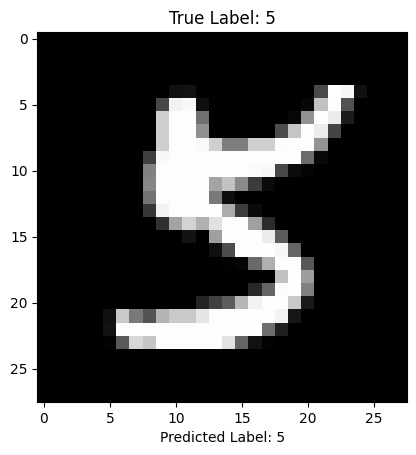

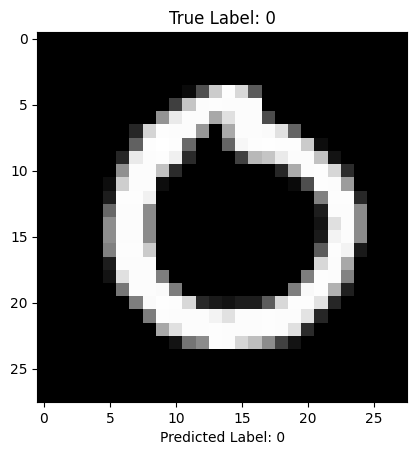

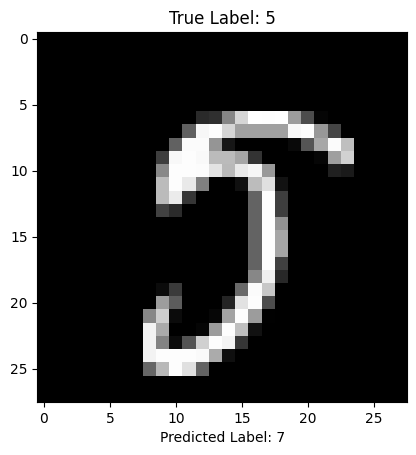

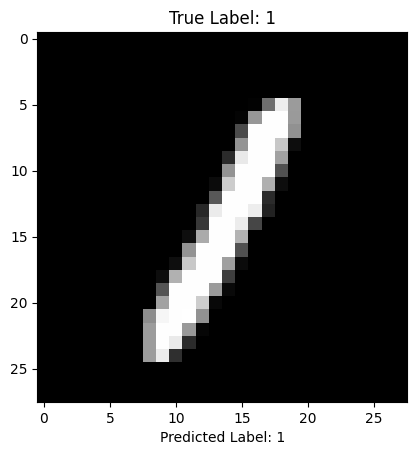

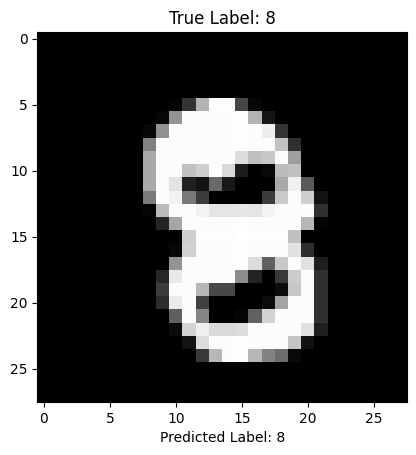

In [18]:
# Протестуйте навчену нейромережу на 10 зображеннях. З тестової вибірки візьміть 5
# випадкових зображень і передайте їх у нейронну мережу.
# Виведіть зображення та випишіть  поруч відповідь нейромережі.
# Зробіть висновок про те, чи помиляється твоя нейронна мережа, і якщо так, то як часто?

import random

# Вибираємо 5 випадкових зображень
random_indices = random.sample(range(len(x_test)), 5)
sample_images = x_test[random_indices]
sample_labels = y_test[random_indices]

# Виведення зображень та передача їх у нейронну мережу
for i in range(5):
    image = sample_images[i].reshape((28, 28))
    label = sample_labels[i]

    # Відображення зображення
    plt.imshow(image, cmap='gray')
    plt.title(f"True Label: {label}")

    # Передача зображення у нейронну мережу
    prediction = neural_net(sample_images[i:i+1])
    predicted_label = tf.argmax(prediction, axis=1).numpy()[0]

    plt.xlabel(f"Predicted Label: {predicted_label}")
    plt.show()

Висновки:
Точність нейромережі на тестових даних складає 90.13%, що є високим показником для короткого часу навчання. Проте, цього недостатньо для використання в реальних завданнях, тому слід обережно ставитися до результатів моделі.

Порівняння прогнозів з правильними значеннями показує, що модель добре навчена, але не досконала. Вона розпізнає цифри, але робить помилки, особливо на складних прикладах.

Модель помиляється приблизно 1 раз з 5-ти. Помилки виникають на складних прикладах, та тих, що важко розпізнати навіть людині. Це через значну схожість з іншими цифрами, які мають багато схожих пікселів, що ускладнює їх розпізнавання.

Покращення моделі можна досягти шляхом збільшення кількості навчальних епох, використанням більш складних архітектур або застосуванням методів регуляризації для запобігання перенавчанню.

Загалом, модель показує хороші результати для початкового етапу, але потребує подальшого вдосконалення для досягнення більшої точності та надійності в розпізнаванні цифр.